In [80]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 10.1

In [2]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1

#### Code 10.2

In [3]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, a]
100%|██████████| 2000/2000 [00:01<00:00, 1235.25it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '6908' (I am process '6909')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/rosgori/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '6908' (I am process '6910')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/rosgori/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '6909' (I am process '6910')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/rosgori/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/loc

In [4]:
df_10_1 = pm.summary(trace_10_1, alpha=.11)
df_10_1.round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.32,0.09,0.00,0.17,0.46,4240.10,1.0
bp,0.48,9.96,0.15,-15.32,15.83,3804.34,1.0


#### Code 10.3

In [5]:
logistic(df_10_1.iloc[:,3:5]).round(5)

,hpd_5.5,hpd_94.5
a,0.54239,0.6119
bp,0.00000,1.0000


#### Code 10.4

In [6]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, a]
100%|██████████| 2000/2000 [00:03<00:00, 642.04it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bpC, bp, a]
100%|██████████| 2000/2000 [00:04<00:00, 456.08it/s]


#### Code 10.5

In [7]:
comp_df = pm.compare({model_10_1 : trace_10_1,
                      model_10_2 : trace_10_2,
                      model_10_3 : trace_10_3},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2', 'm10.3'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.2,680.42,1.96,0,0.72,9.33,0,0
m10.3,682.4,3.03,1.97,0.27,9.46,0.75,0
m10.1,687.96,1.01,7.54,0.02,7.1,6.2,0


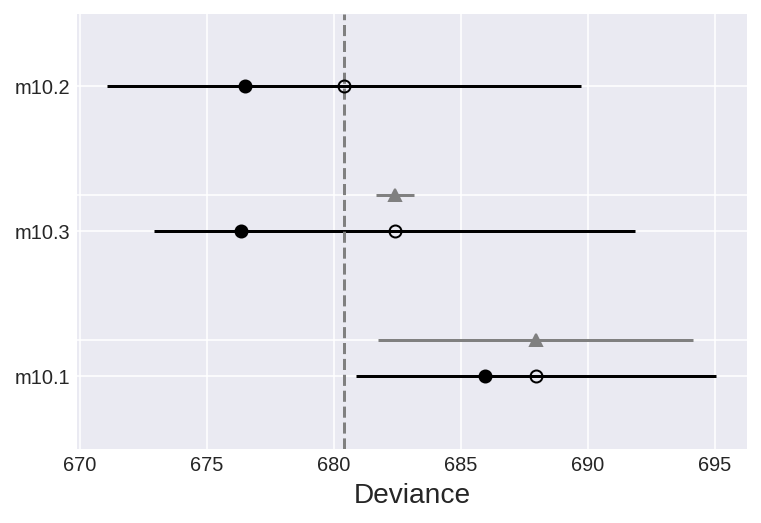

In [8]:
pm.compareplot(comp_df);

#### Code 10.6

In [9]:
pm.summary(trace_10_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.05,0.13,0.00,-0.15,0.26,2283.80,1.0
bp,0.62,0.22,0.01,0.24,0.97,2237.73,1.0
bpC,-0.10,0.27,0.01,-0.53,0.31,2499.53,1.0


#### Code 10.7

In [10]:
np.exp(0.61)

1.8404313987816374

#### Code 10.8

In [11]:
logistic(4)

0.9820137900379085

#### Code 10.9

In [12]:
logistic(4 + 0.61)

0.9901462444767687

#### Code 10.10 and 10.11

In [13]:
d_pred = pd.DataFrame({'prosoc_left' : [0, 1, 0, 1], 'condition' : [0, 0, 1, 1]})
traces = [trace_10_1, trace_10_2, trace_10_3]
models = [model_10_1, model_10_2, model_10_3]


chimp_ensemble = pm.sample_ppc_w(traces=traces, models=models, samples=1000, weights=comp_df.weight.sort_index(ascending=True))

100%|██████████| 1000/1000 [00:00<00:00, 2436.31it/s]


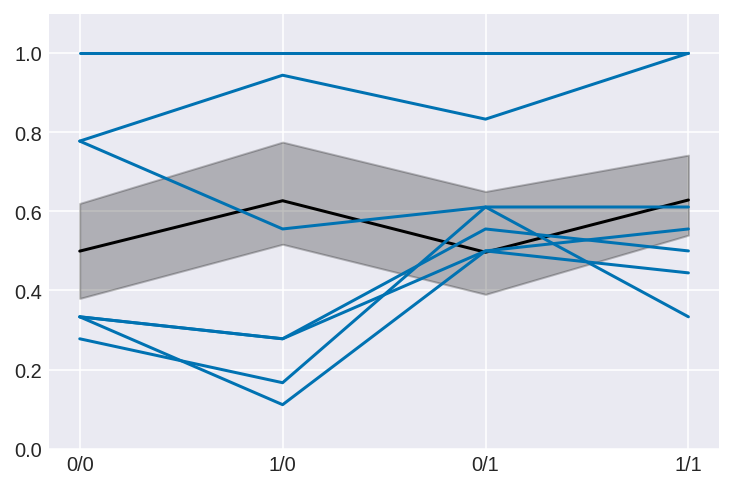

In [14]:
rt = chimp_ensemble['pulled_left']
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()

for i in range(len(rt)):
    tmp = []
    if rt[i].size < 2:
        continue
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left==pl) & (d.chose_prosoc==cp)]))
    pred_mean[i] = tmp
    
ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
for i in range(7):
    plt.plot(chimps[i], 'C0')

plt.ylim(0, 1.1);

#### Code 10.12 & 10.13
This is the same as 10.6, but in the book using MCMC rather than quadratic approximation.

#### Code 10.14

In [15]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bpC, bp, alpha]
100%|██████████| 2000/2000 [00:07<00:00, 282.30it/s]
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.


#### Code 10.15

In [16]:
# remember we use a zero-index
d['actor'].unique()

array([0, 1, 2, 3, 4, 5, 6])

#### Code 10.16

In [17]:
pm.summary(trace_10_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha__0,-0.74,0.27,0.01,-1.16,-0.28,2670.66,1.0
alpha__1,9.54,3.74,0.09,3.59,15.22,1778.52,1.0
alpha__2,-1.04,0.28,0.00,-1.48,-0.61,2824.60,1.0
alpha__3,-1.04,0.28,0.01,-1.46,-0.58,2856.50,1.0
alpha__4,-0.73,0.27,0.00,-1.14,-0.28,3030.92,1.0
alpha__5,0.23,0.27,0.00,-0.21,0.66,3011.81,1.0
alpha__6,1.82,0.39,0.01,1.16,2.37,3190.34,1.0
bp,0.83,0.26,0.01,0.40,1.24,2069.44,1.0
bpC,-0.13,0.30,0.01,-0.61,0.33,2515.33,1.0


#### Code 10.17

In [18]:
post = pm.trace_to_dataframe(trace_10_4)
post.head()

,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6,bp,bpC
0,-0.703337,12.407791,-1.172228,-1.562585,-1.134960,0.519253,2.237650,0.994483,-0.139041
1,-0.923262,10.880359,-1.187311,-0.818166,-0.457212,-0.134173,1.221130,0.976647,-0.523694
2,-1.002489,5.941561,-0.921724,-0.873801,-0.812690,0.200093,1.791229,0.872044,-0.227060
3,-0.429103,7.003254,-1.315064,-0.371106,-0.857778,0.386100,1.218528,0.645609,-0.217118
4,-0.268475,8.979925,-1.030307,-1.153134,-0.739745,0.192895,1.575561,0.832352,0.079598


#### Code 10.18

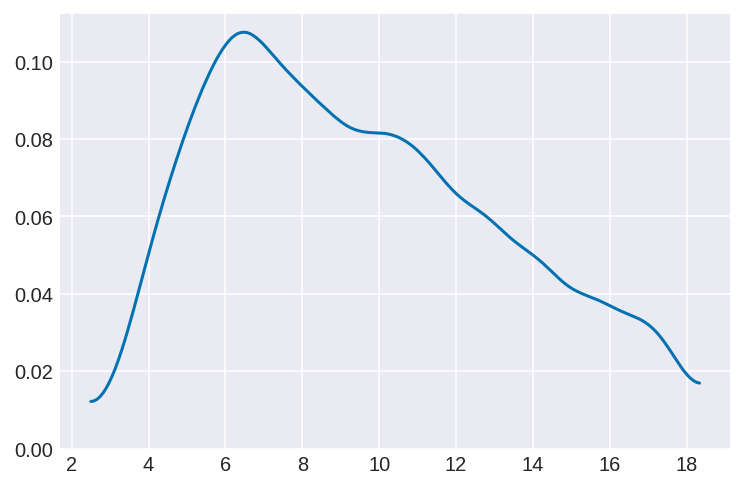

In [19]:
pm.kdeplot(post['alpha__1']);

#### Code 10.19

In [20]:
rt = pm.sample_ppc(trace_10_4, 1000, model_10_4)['pulled_left']

100%|██████████| 1000/1000 [00:00<00:00, 2498.25it/s]


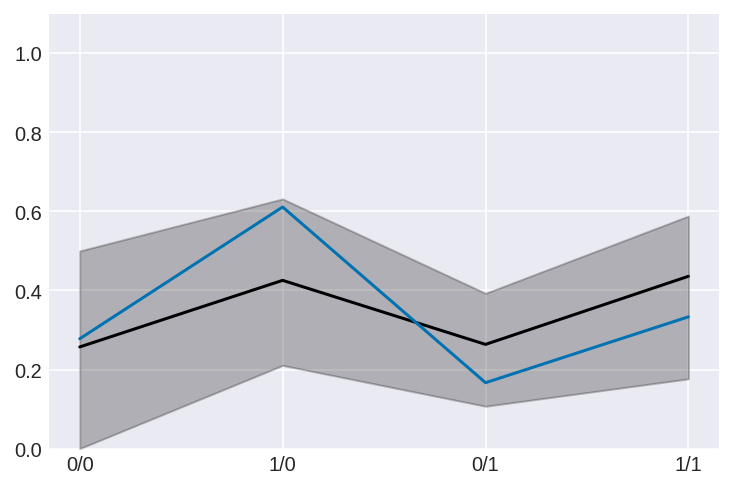

In [21]:
chimp = 2
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left == pl) & (d.chose_prosoc == cp) & (d.actor == chimp)]))
    pred_mean[i] = tmp

ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean, alpha=0.11)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d[d.actor == chimp].groupby(['condition', 'prosoc_left', ]).agg('mean')['pulled_left'].values
plt.plot(chimps, 'C0')

plt.ylim(0, 1.1);

#### Code 10.20

In [22]:
d_aggregated = d.groupby(['actor', 'condition', 'prosoc_left',  ])['pulled_left'].sum().reset_index()
d_aggregated.head(8)

,actor,condition,prosoc_left,pulled_left
0,0,0,0,6
1,0,0,1,9
2,0,1,0,5
3,0,1,1,10
4,1,0,0,18
5,1,0,1,18
6,1,1,0,18
7,1,1,1,18


#### Code 10.21

In [23]:
with pm.Model() as model_10_5:
    a = pm.Normal('alpha', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d_aggregated.condition) * d_aggregated.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_10_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bpC, bp, alpha]
100%|██████████| 2000/2000 [00:03<00:00, 656.60it/s]


In [24]:
pm.summary(trace_10_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.05,0.13,0.00,-0.15,0.27,2234.63,1.0
bp,0.61,0.23,0.00,0.23,0.95,2239.43,1.0
bpC,-0.10,0.27,0.01,-0.52,0.35,2461.12,1.0


In [25]:
# hacky check of similarity to 10_3, within a hundreth
np.isclose(pm.summary(trace_10_5), pm.summary(trace_10_3), atol=0.01)

array([[ True,  True,  True,  True,  True, False,  True],
       [ True,  True,  True,  True, False, False,  True],
       [ True,  True,  True, False, False, False,  True]])

#### Code 10.22

In [26]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad.head(8)

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375


#### Code 10.23

In [27]:
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)

with pm.Model() as model_10_6:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a + bm * d_ad.male)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_6 = pm.sample(1000, tune=1000)
    
with pm.Model() as model_10_7:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bm, a]
100%|██████████| 2000/2000 [00:02<00:00, 825.83it/s]
The acceptance probability does not match the target. It is 0.8828537087895417, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
100%|██████████| 2000/2000 [00:01<00:00, 1672.16it/s]
The acceptance probability does not match the target. It is 0.8806785759916747, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 10.24

In [28]:
# Something goofy here... 
# not even close to WAIC values, larger standard error

comp_df = pm.compare({model_10_6 : trace_10_6,
                      model_10_7 : trace_10_7}, method = 'pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7'])
comp_df = comp_df.set_index('model')
comp_df

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.6,991.88,112.49,0,1,312.34,0,1
m10.7,1045.99,82.32,54.11,0,313.73,157.37,1


#### Code 10.25

In [29]:
pm.summary(trace_10_6, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.83,0.05,0.0,-0.91,-0.75,977.23,1.0
bm,0.61,0.06,0.0,0.50,0.70,976.82,1.0


#### Code 10.26

In [30]:
post = pm.trace_to_dataframe(trace_10_6)
p_admit_male = logistic(post['a'] + post['bm'])
p_admit_female = logistic(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

2.5%     0.112704
50%      0.141174
97.5%    0.169595
dtype: float64

#### Code 10.27

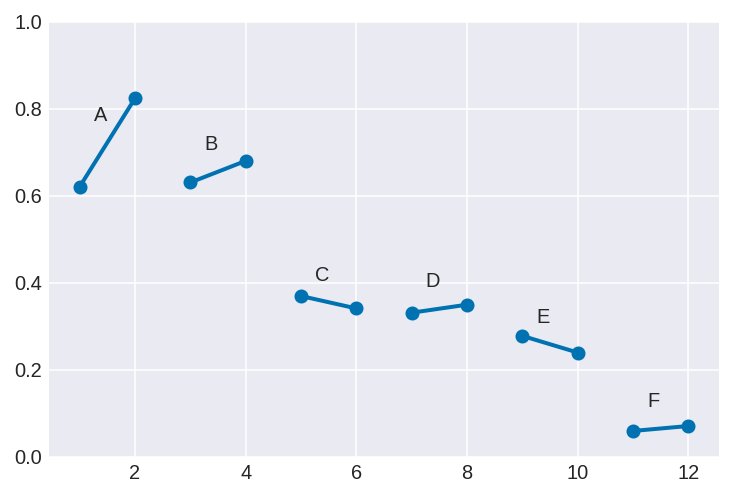

In [31]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])
plt.ylim(0, 1);

#### Code 10.28

In [32]:
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [33]:
with pm.Model() as model_10_8:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_9:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a[d_ad['dept_id'].values] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
100%|██████████| 2000/2000 [00:02<00:00, 824.49it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bm, a]
100%|██████████| 2000/2000 [00:03<00:00, 549.13it/s]


#### Code 10.29

In [34]:
# WAIC values still off
# Plus warning flag

comp_df = pm.compare({model_10_6 : trace_10_6,
                      model_10_7 : trace_10_7,
                      model_10_8 : trace_10_8,
                      model_10_9 : trace_10_9},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7', 'm10.8', 'm10.9'])
comp_df = comp_df.set_index('model')
comp_df

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.8,105.75,6.88,0,0.79,17.35,0,1
m10.9,108.44,9.39,2.68,0.21,15.43,3.91,1
m10.6,991.88,112.49,886.13,0,312.34,309.27,1
m10.7,1045.99,82.32,940.24,0,313.73,311.27,1


#### Code 10.30

In [35]:
pm.summary(trace_10_9, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.68,0.10,0.0,0.52,0.84,3147.79,1.0
a__1,0.64,0.11,0.0,0.45,0.81,3577.76,1.0
a__2,-0.58,0.08,0.0,-0.70,-0.46,4044.37,1.0
a__3,-0.61,0.08,0.0,-0.75,-0.48,4223.42,1.0
a__4,-1.06,0.10,0.0,-1.21,-0.90,5309.40,1.0
a__5,-2.64,0.16,0.0,-2.89,-2.37,5253.67,1.0
bm,-0.10,0.08,0.0,-0.22,0.03,2728.28,1.0


#### Code 10.31
Replicated model above but with MCMC in book.

#### Code 10.32

In [36]:
import statsmodels.api as sm
from patsy import dmatrix

endog = d_ad.loc[:,['admit', 'reject']].values # cbind(admit,reject)

m10_7glm = sm.GLM(endog, dmatrix('~ 1', data=d_ad), 
                  family=sm.families.Binomial())
m10_6glm = sm.GLM(endog, dmatrix('~ male', data=d_ad), 
                  family=sm.families.Binomial())
m10_8glm = sm.GLM(endog, dmatrix('~ dept_id', data=d_ad), 
                  family=sm.families.Binomial())
m10_9glm = sm.GLM(endog, dmatrix('~ male + dept_id', data=d_ad), 
                  family=sm.families.Binomial())
# res = m10_7glm.fit()
# res.summary()

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Code 10.33

In [37]:
import statsmodels.formula.api as smf
m10_4glm = smf.glm(formula='pulled_left ~ actor + prosoc_left*condition - condition', data=d, 
                   family=sm.families.Binomial())

#### Code 10.34

In [38]:
pm.GLM.from_formula('pulled_left ~ actor + prosoc_left*condition - condition', 
                    family='binomial', data=d)   

#### Code 10.35

In [39]:
# outcome and predictor almost perfectly associated
y = np.hstack([np.ones(10,)*0, np.ones(10,)])
x = np.hstack([np.ones(9,)*-1, np.ones(11,)])

m_bad = smf.glm(formula='y ~ x', 
                data=pd.DataFrame({'y':y, 'x':x}), 
                family=sm.families.Binomial()).fit()
m_bad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3.3510
Date:                Wed, 25 Apr 2018   Deviance:                       6.7020
Time:                        17:18:56   Pearson chi2:                     11.0
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1317   8032.690     -0.001      0.999   -1.58e+04    1.57e+04
x             12.4343   8032.690      0.002      0.999   -1.57e+04    1.58e+04
==============================================================================
"""

#### Code 10.36

In [40]:
with pm.Model() as m_good:
    ab = pm.Normal('ab', 0, 10, shape=2)
    p = pm.math.invlogit(ab[0] + ab[1]*x)
    y_ = pm.Binomial('y_', 1, p, observed=y)
    
    MAP = pm.find_MAP()
MAP

logp = -9.9185, ||grad|| = 7.2889e-05: 100%|██████████| 13/13 [00:00<00:00, 2351.88it/s]  


{'ab': array([-1.72704484,  4.01710522])}

#### Code 10.37

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab]
100%|██████████| 2000/2000 [00:03<00:00, 532.35it/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7114540601535866, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885123369337046, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


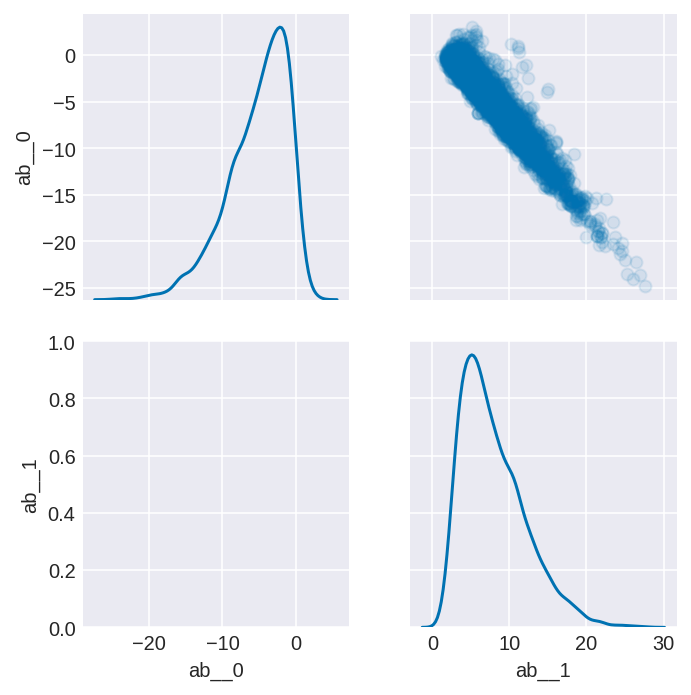

In [41]:
trace = pm.sample(1000, tune=1000, model=m_good)
tracedf = pm.trace_to_dataframe(trace)
grid = (sns.PairGrid(tracedf,
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1))

#### Code 10.38

In [42]:
y = stats.binom.rvs(n=1000, p=1/1000, size=100000)
np.mean(y), np.var(y)

(0.99541, 0.9949089319000001)

#### Code 10.39

In [43]:
dk = pd.read_csv('Data/Kline', sep=';')
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Code 10.40

In [44]:
dk.log_pop = np.log(dk.population)
dk.contact_high = (dk.contact == "high").astype(int)

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [45]:
from theano import shared
# casting data to theano shared variable. 
# It is for out of sample prediction from model with sampled trace
log_pop = shared(dk.log_pop.values)
contact_high = shared(dk.contact_high.values)
total_tools = shared(dk.total_tools.values)

#### Code 10.41

In [46]:
with pm.Model() as m_10_10:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:15<00:00, 126.00it/s]


#### Code 10.42

In [47]:
summary = pm.summary(trace_10_10, alpha=.11)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]
trace_cov = pm.trace_cov(trace_10_10, model=m_10_10)
invD = (np.sqrt(np.diag(trace_cov))**-1)[:, None]
trace_corr = pd.DataFrame(invD*trace_cov*invD.T, index=summary.index, columns=summary.index)

summary.join(trace_corr).round(2)

,mean,sd,hpd_5.5,hpd_94.5,a,b__0,b__1,b__2
a,0.95,0.36,0.37,1.51,1.00,-0.97,-0.13,0.07
b__0,0.26,0.03,0.21,0.32,-0.97,1.00,0.13,-0.09
b__1,-0.09,0.84,-1.49,1.19,-0.13,0.13,1.00,-0.99
b__2,0.04,0.09,-0.10,0.20,0.07,-0.09,-0.99,1.00


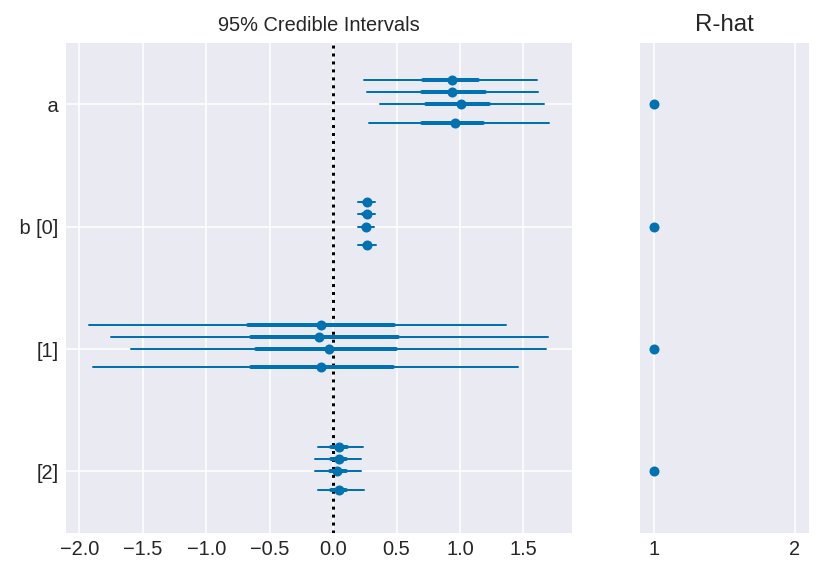

In [48]:
pm.forestplot(trace_10_10);

#### Code 10.43

In [49]:
lambda_high = np.exp(trace_10_10['a'] + trace_10_10['b'][:,1] + (trace_10_10['b'][:,0] + trace_10_10['b'][:,2]) * 8)
lambda_low = np.exp(trace_10_10['a'] + trace_10_10['b'][:,0] * 8 )

#### Code 10.44

In [50]:
diff = lambda_high - lambda_low
np.sum(diff > 0) / len(diff)

0.95725

#### Code 10.45

In [51]:
with pm.Model() as m_10_11:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=2)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:08<00:00, 248.29it/s]
The acceptance probability does not match the target. It is 0.8824815617924094, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 10.46

In [52]:
with pm.Model() as m_10_12:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_12 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_10_13:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:05<00:00, 392.35it/s]
The acceptance probability does not match the target. It is 0.8897402874182364, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:02<00:00, 920.97it/s]




#### Code 10.47

In [53]:
with pm.Model() as m_10_14:
    a = pm.Normal('a', 0, 100)
    lam = pm.math.exp(a)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
100%|██████████| 2000/2000 [00:01<00:00, 1803.41it/s]
The acceptance probability does not match the target. It is 0.8857726822532956, but should be close to 0.8. Try to increase the number of tuning steps.


In [57]:
traces = [trace_10_10, trace_10_11, trace_10_12, trace_10_13, trace_10_14]
models = [m_10_10, m_10_11, m_10_12, m_10_13, m_10_14]

dictionary = dict(zip(models, traces))

islands_compare = pm.compare(dictionary, method='pseudo-BMA')

islands_compare.loc[:,'model'] = pd.Series(['m10.10', 'm10.11', 'm10.12', 'm10.13', 'm10.14'])
islands_compare = islands_compare.set_index('model')
islands_compare

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.11,78.93,4.13,0,0.61,11.02,0,1
m10.10,80.07,4.84,1.15,0.34,11.29,1.19,1
m10.12,84.13,3.61,5.2,0.05,8.94,7.95,1
m10.14,141.78,8.36,62.85,0,31.82,32.9,1
m10.13,149.97,16.55,71.04,0,44.65,44.32,1


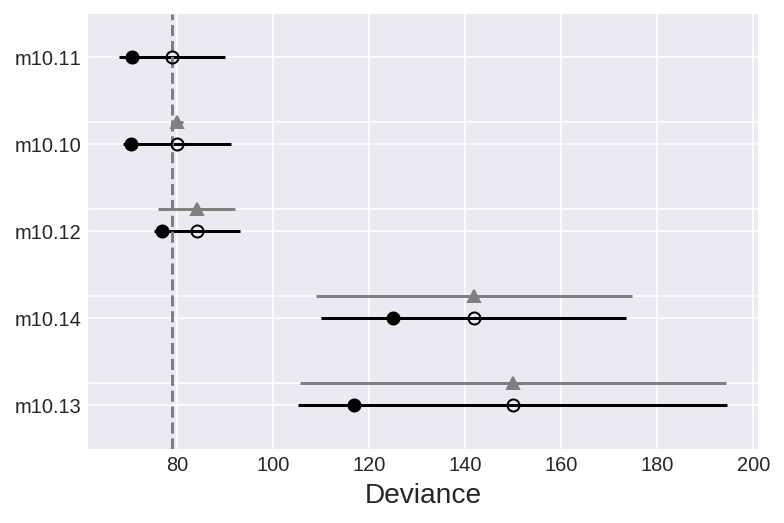

In [58]:
pm.compareplot(islands_compare);

#### Code 10.48

In [59]:
# set new value for out-of-sample prediction 
log_pop_seq = np.linspace(6, 13, 30)
log_pop.set_value(np.hstack([log_pop_seq, log_pop_seq]))
contact_high.set_value(np.hstack([np.repeat(0, 30), np.repeat(1, 30)]))

islands_ensemble = pm.sample_ppc_w(traces, 10000, 
                                   models, weights=islands_compare.weight.sort_index(ascending=True))

100%|██████████| 10000/10000 [00:02<00:00, 3833.23it/s]


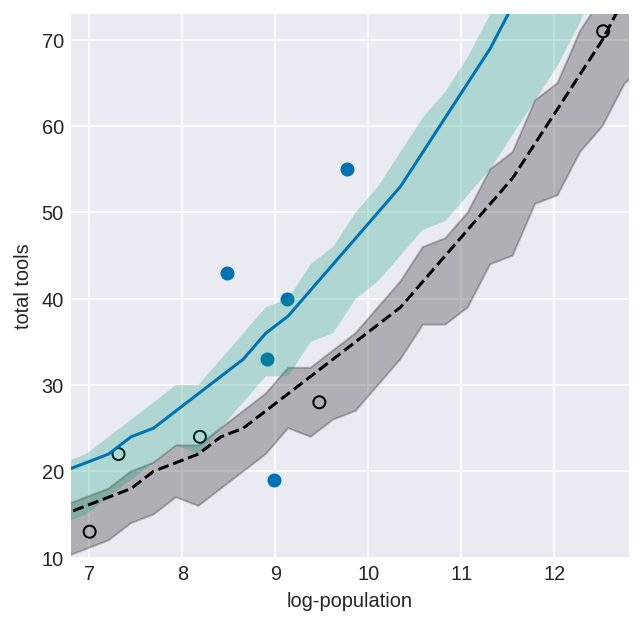

In [60]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
index = dk.contact_high==1
axes.scatter(np.log(dk.population)[~index], dk.total_tools[~index],
             facecolors='none', edgecolors='k', lw=1)
axes.scatter(np.log(dk.population)[index], dk.total_tools[index])

mp = islands_ensemble['total_tools'][:, :30]
mu_hpd = pm.hpd(mp, alpha=.50)

axes.plot(log_pop_seq, np.median(mp, axis=0), '--', color='k')
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=0.25, color='k')

mp = islands_ensemble['total_tools'][:, 30:]
mu_hpd = pm.hpd(mp, alpha=.50)

axes.plot(log_pop_seq, np.median(mp, axis=0))
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=0.25)
axes.set_xlabel('log-population')
axes.set_ylabel('total tools')
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

#### Code 10.49
This is the same as 10.41, but in the book using MCMC rather than MAP.

In [61]:
pm.summary(trace_10_10, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.95,0.36,0.01,0.37,1.51,1505.40,1.0
b__0,0.26,0.03,0.00,0.21,0.32,1504.60,1.0
b__1,-0.09,0.84,0.02,-1.49,1.19,1391.83,1.0
b__2,0.04,0.09,0.00,-0.10,0.20,1391.18,1.0


#### Code 10.50

In [62]:
log_pop_c = dk.log_pop.values - dk.log_pop.values.mean()
log_pop.set_value(log_pop_c)
contact_high.set_value(dk.contact_high.values)
total_tools.set_value(dk.total_tools.values)

with pm.Model() as m_10_10c:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10c = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:03<00:00, 579.60it/s]


In [63]:
pm.summary(trace_10_10c, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.31,0.09,0.0,3.17,3.45,2554.40,1.0
b__0,0.26,0.04,0.0,0.21,0.32,2895.02,1.0
b__1,0.28,0.12,0.0,0.11,0.48,2595.56,1.0
b__2,0.07,0.17,0.0,-0.21,0.34,3476.37,1.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


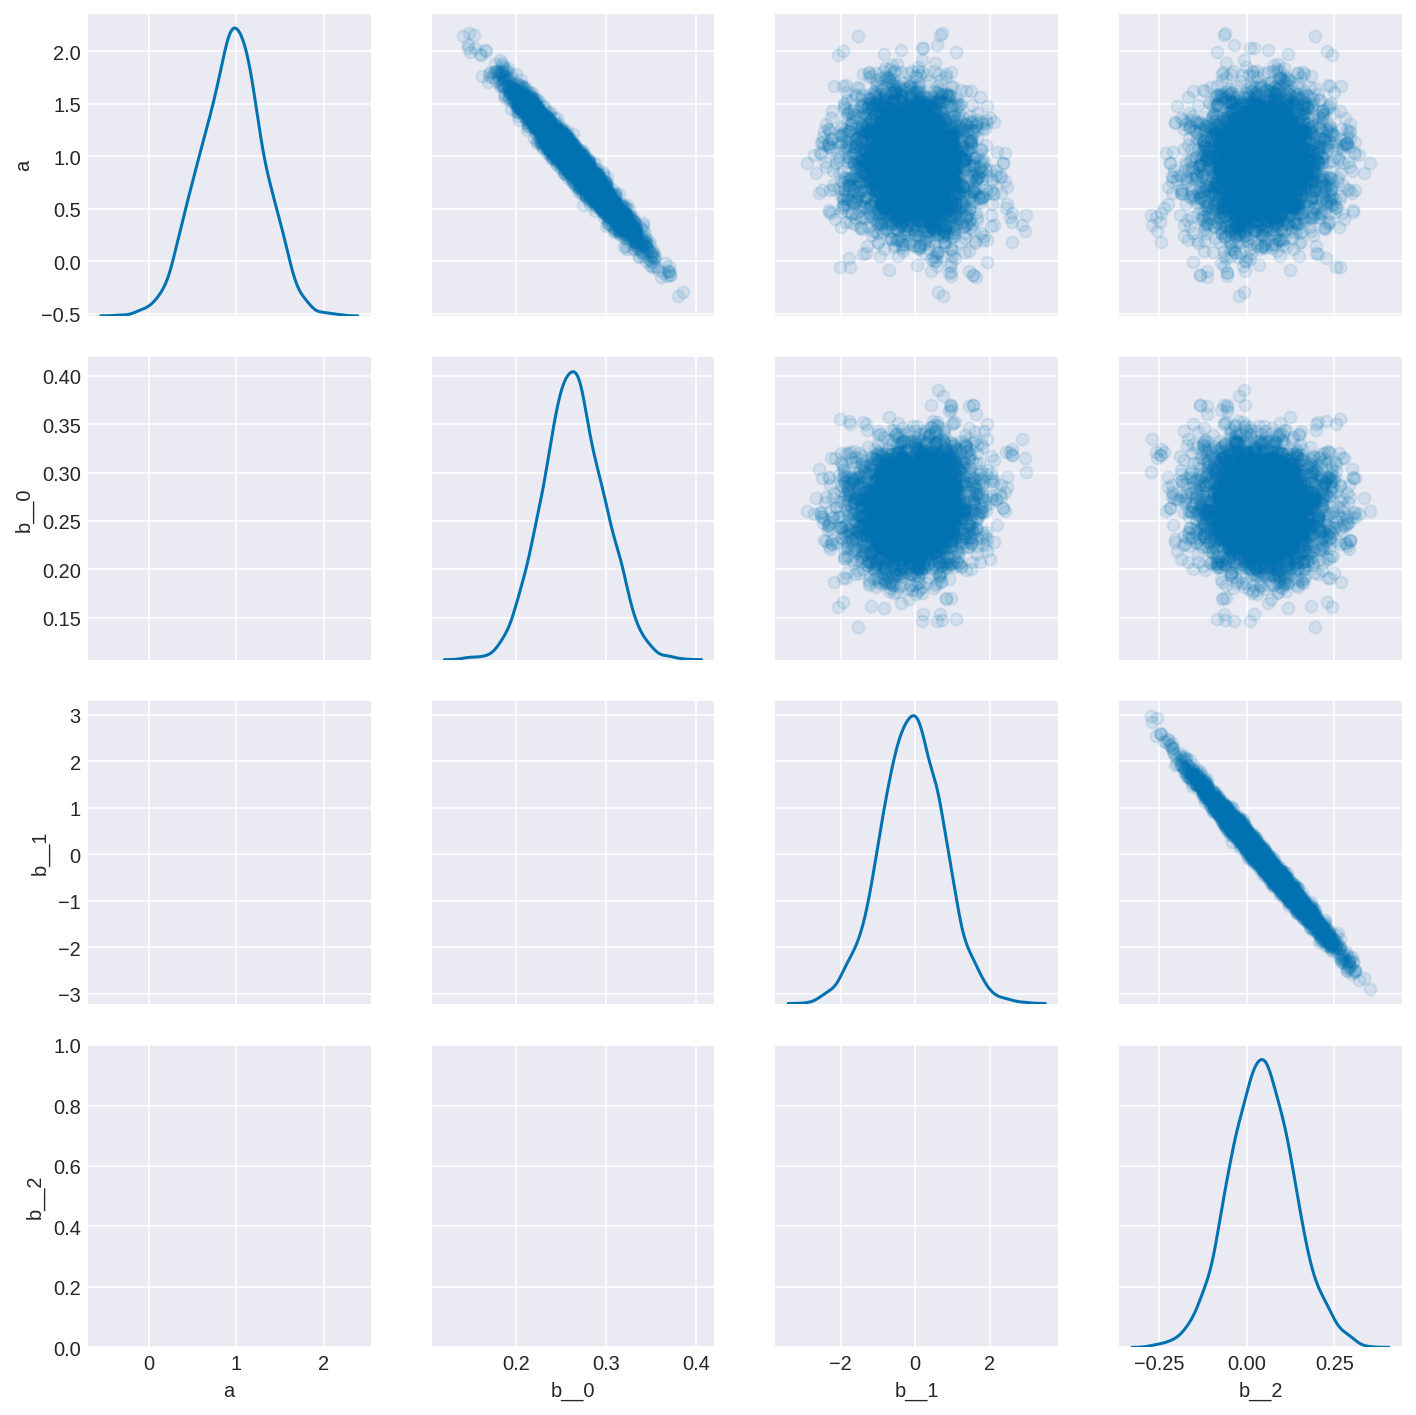

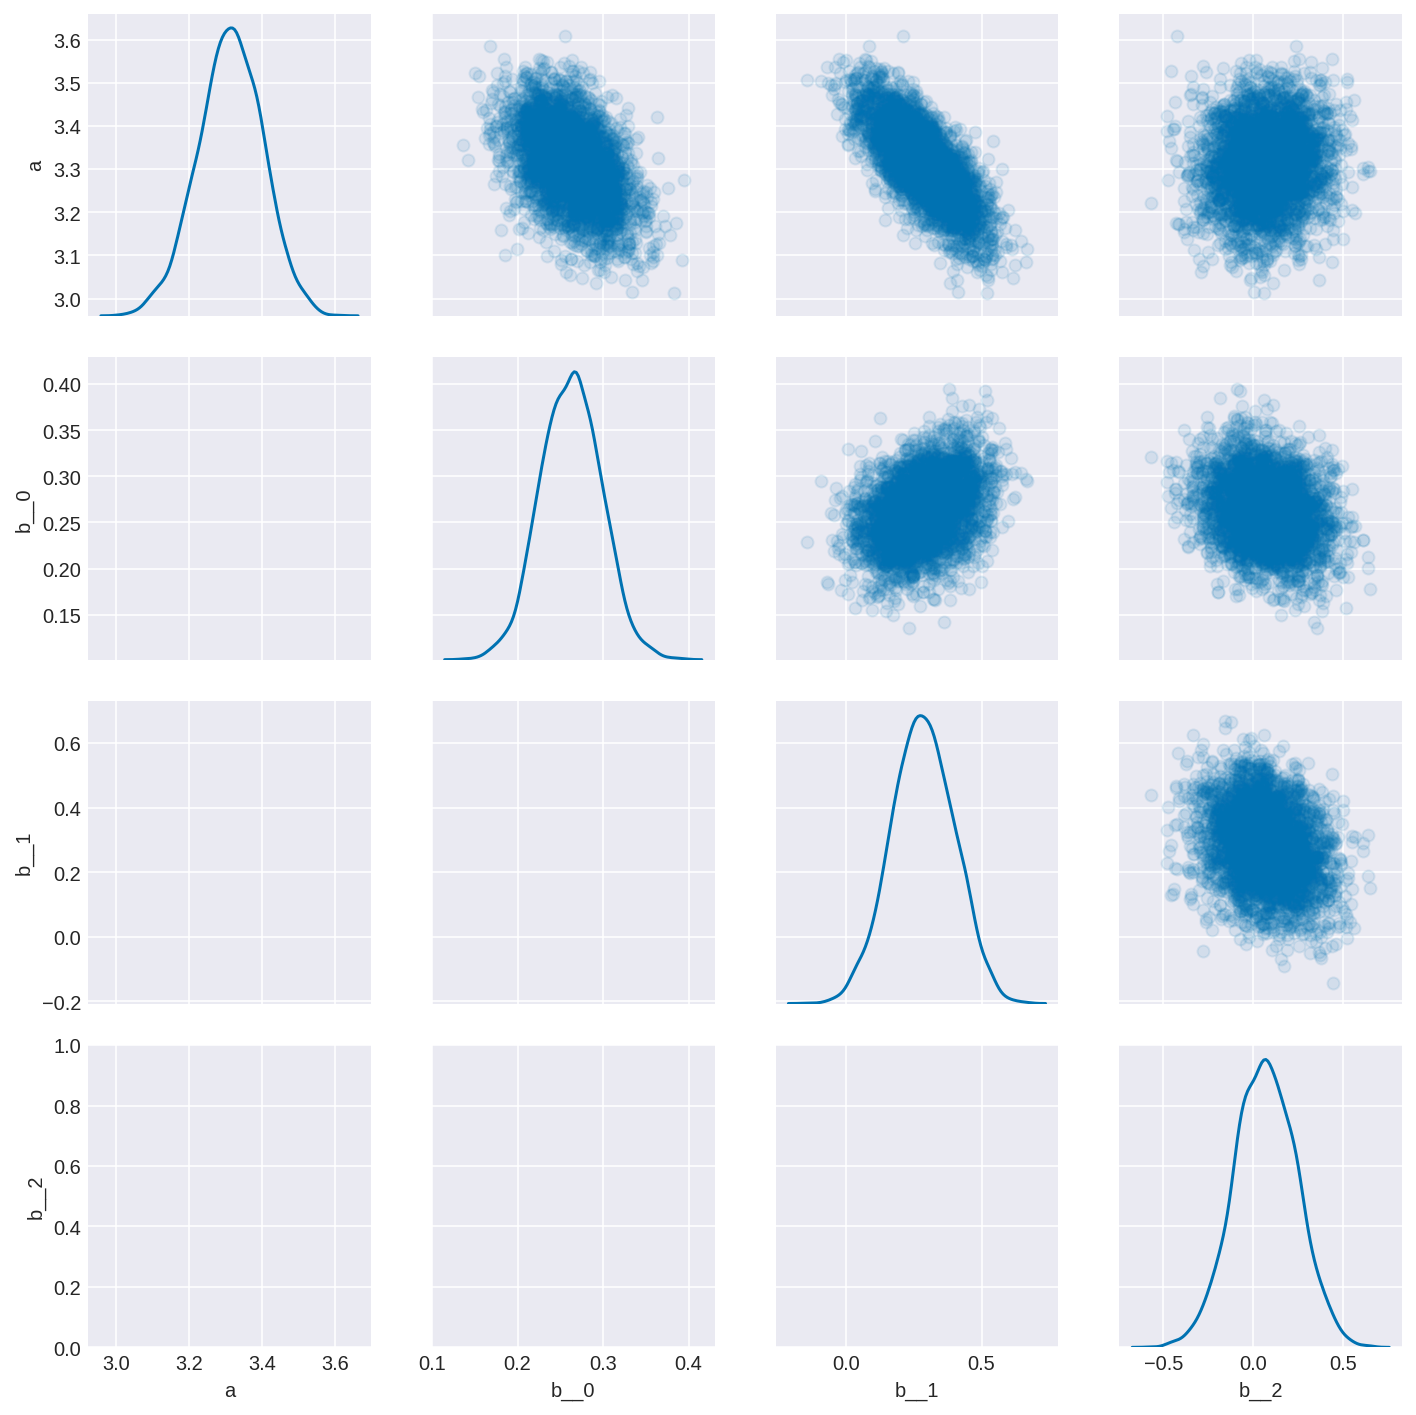

In [64]:
for trace in [trace_10_10, trace_10_10c]:
    tracedf = pm.trace_to_dataframe(trace)
    grid = (sns.PairGrid(tracedf,
                         diag_sharey=False)
               .map_diag(sns.kdeplot)
               .map_upper(plt.scatter, alpha=0.1))

#### Code 10.51

In [65]:
num_days = 30
y = np.random.poisson(1.5, num_days)

#### Code 10.52

In [66]:
num_weeks = 4
y_new = np.random.poisson(0.5*7, num_weeks)

#### Code 10.53

In [67]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)]).astype('float')
monastery = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])

#### Code 10.54

In [68]:
log_days = np.log(exposure)
with pm.Model() as m_10_15:
    a = pm.Normal('a', 0., 100.)
    b = pm.Normal('b', 0., 1.)
    lam = pm.math.exp(log_days + a + b*monastery)
    obs = pm.Poisson('y', lam, observed=y_all)
    trace_10_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:02<00:00, 998.76it/s]


#### Code 10.55

In [69]:
trace_10_15.add_values(dict(lambda_old=np.exp(trace_10_15['a']),
                            lambda_new=np.exp(trace_10_15['a'] + trace_10_15['b'])))

pm.summary(trace_10_15, varnames=['lambda_old', 'lambda_new'], alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
lambda_old,1.27,0.20,0.0,0.93,1.58,2208.61,1.0
lambda_new,0.46,0.13,0.0,0.27,0.67,2823.24,1.0


#### Code 10.56

In [70]:
# simulate career choices among 500 individuals
N = 500                 # number of individuals
income = np.arange(3)+1 # expected income of each career
score = 0.5*income      # scores for each career, based on income
# next line converts scores to probabilities
def softmax(w):
    e = np.exp(w)
    return e/np.sum(e, axis=0)

p = softmax(score)
# now simulate choice
# outcome career holds event type values, not counts
career = np.random.multinomial(1, p, size=N)
career = np.where(career==1)[1]

#### Code 10.57

In [71]:
import theano.tensor as tt
with pm.Model() as m_10_16:
    b = pm.Normal('b', 0., 5.)
    s2 = b*2
    s3 = b*3
    p_ = tt.stack([b, s2, s3])
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    trace_10_16 = pm.sample(1000, tune=1000)
pm.summary(trace_10_16, alpha=.11).round(2)

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
100%|██████████| 2000/2000 [00:01<00:00, 1024.01it/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
b,0.49,0.06,0.0,0.4,0.58,1723.33,1.0


#### Code 10.58

In [72]:
N = 100
# simulate family incomes for each individual
family_income = np.random.rand(N)
# assign a unique coefficient for each type of event
b = np.arange(3)-1
p = softmax(score[:, None] + np.outer(b, family_income)).T
career = np.asarray([np.random.multinomial(1, pp) for pp in p])
career = np.where(career==1)[1]

In [73]:
with pm.Model() as m_10_17:
    a23 = pm.Normal('a23', 0, 5, shape=2)
    b23 = pm.Normal('b23', 0, 5, shape=2)
    s2 = a23[0] + b23[0]*family_income
    s3 = a23[1] + b23[1]*family_income
    p_ = tt.stack([np.zeros(N), s2, s3]).T
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    trace_10_17 = pm.sample(1000, tune=1000)
pm.summary(trace_10_17, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b23, a23]
100%|██████████| 2000/2000 [00:11<00:00, 177.18it/s]
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a23__0,0.51,0.64,0.02,-0.48,1.55,987.61,1.0
a23__1,0.40,0.63,0.02,-0.63,1.36,1047.86,1.0
b23__0,2.88,1.86,0.06,-0.01,5.83,975.88,1.0
b23__1,4.95,1.79,0.05,2.07,7.64,969.72,1.0


#### Code 10.59

In [74]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')

#### Code 10.60

In [75]:
# binomial model of overall admission probability
with pm.Model() as m_binom:
    a = pm.Normal('a', 0, 100)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    trace_binom = pm.sample(1000, tune=1000)
    
# Poisson model of overall admission rate and rejection rate
with pm.Model() as m_pois:
    a = pm.Normal('a', 0, 100, shape=2)
    lam = pm.math.exp(a)
    admit = pm.Poisson('admit', lam[0], observed=d_ad.admit)
    rej = pm.Poisson('rej', lam[1], observed=d_ad.reject)
    trace_pois = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
100%|██████████| 2000/2000 [00:01<00:00, 1736.77it/s]
The acceptance probability does not match the target. It is 0.8830257995114367, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
100%|██████████| 2000/2000 [00:01<00:00, 1096.27it/s]


#### Code 10.61

In [76]:
m_binom = pm.summary(trace_binom, alpha=.11).round(2)
logistic(m_binom['mean'])

a    0.386986
Name: mean, dtype: float64

#### Code 10.62

In [77]:
m_pois = pm.summary(trace_pois, alpha=.11).round(2)
m_pois['mean'][0]
np.exp(m_pois['mean'][0])/(np.exp(m_pois['mean'][0])+np.exp(m_pois['mean'][1]))

0.38698582386066455

#### Code 10.63

In [78]:
# simulate
N = 100
x = np.random.rand(N)
y = np.random.geometric(logistic(-1 + 2*x), size=N)

with pm.Model() as m_10_18:
    a = pm.Normal('a', 0, 10)
    b = pm.Normal('b', 0, 1)
    p = pm.math.invlogit(a + b*x)
    obs = pm.Geometric('y', p=p, observed=y)
    trace_10_18 = pm.sample(1000, tune=1000)
pm.summary(trace_10_18, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:03<00:00, 657.12it/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.12,0.21,0.01,-1.46,-0.78,1420.14,1.0
b,2.32,0.44,0.01,1.65,3.08,1459.56,1.0


In [79]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.4
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
Pandas 0.22.0
SciPy 1.0.1
Matplotlib 2.2.2

